In [1]:
import numpy as np
from gekko import gekko as ge
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def plotter(data, action, battery, net_energy, act, battery_, net_energy_, price, load, solar, wind):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 4))
    x = range(len(price))

    if data:
        axes[0].plot(x, price, color='red')
        axes[0].set_title('price')

    if action:
        axes[1].plot(x, act, color='black')
        axes[1].set_title('action')

    if battery:
        axes[2].plot(battery_, label='battery')
        axes[2].set_title('battery charge')

    plt.xticks(range(len(price) + 1))
    fig.tight_layout(pad=0.8)
    plt.savefig('optim.png', dpi = 400)
    plt.show()



In [3]:

def solve(steps, load, solar, wind, price,  parameters):
    battery_capacity = parameters['battery_capacity']
    max_battery_charge_per_timestep = parameters['max_battery_charge_per_timestep']
    action_value = parameters['action_value']
    sell_back_price_factor = parameters['sell_back_price_factor']
    initial_charge_on_battery = parameters['initial_charge_on_battery']
    min_charge_on_battery = parameters['min_charge_on_battery']
    emission_rate = parameters['emission_rate']
    lambda_co2 = parameters['lambda_co2']

    m = ge(remote=False, name='House')

    battery = m.Array(f=m.Var, dim=steps + 1, value=initial_charge_on_battery, lb=min_charge_on_battery, ub=battery_capacity)
    action = m.Array(f=m.Var, dim=steps, value=-1, lb=-action_value, ub=action_value)
    net_energy = m.Array(f=m.Var, dim=steps, value=0)
    cost = m.Array(f=m.Var, dim=steps, value=0)
    equations = []

    equations.append(battery[0] == min_charge_on_battery)

    for t in range(steps):
        equations.append(battery[t + 1] == battery[t] + action[t] * max_battery_charge_per_timestep)
        equations.append(net_energy[t] == m.sum([load[t], -solar[t], -wind[t], action[t] * max_battery_charge_per_timestep]))

        cost[t] = m.if3(
            condition=net_energy[t],
            x1=net_energy[t] * (price[t] * sell_back_price_factor),
            x2=net_energy[t] * price[t]
        )

    m.Minimize(lambda_co2 * m.sum(cost) + (1 - lambda_co2) * m.sum(net_energy) * emission_rate)
    m.Equations(equations)
    m.solve(disp=False)

    return m.options.objfcnval, action, battery, net_energy, cost

In [5]:
# Loading the Data
data = pd.read_csv('datasets//test.csv')
load = data.load
solar = 0.24*data.solar
wind = 0.12*data.wind
price = data.price
steps = len(data)


In [6]:
# Defining the Parameters
parameters = {
    'battery_capacity': 100,
    'max_battery_charge_per_timestep': 20,
    'action_value': 1,
    'sell_back_price_factor': 0.5,
    'initial_charge_on_battery': 0,
    'min_charge_on_battery': 0,
    'emission_rate': 50,
    'lambda_co2': 0.8
}


In [7]:
# Optimization Step
reward, action, battery, net_energy, cost= solve(steps, load = load, solar = solar, wind = wind, price = price, parameters = parameters)

In [8]:
# Computing the Optimal Cost
optimalCost = 0
for i in cost:
    optimalCost += i[0]
print(optimalCost)

-397992.2393908221


In [12]:
act = list(action)
battery_ = list(battery)
net_energy_ = list(net_energy)

[]

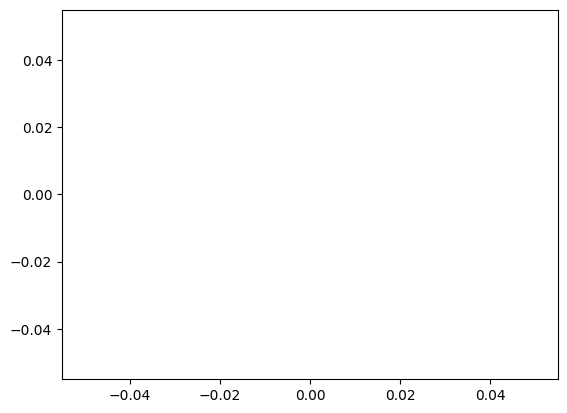

In [13]:
plt.plot()

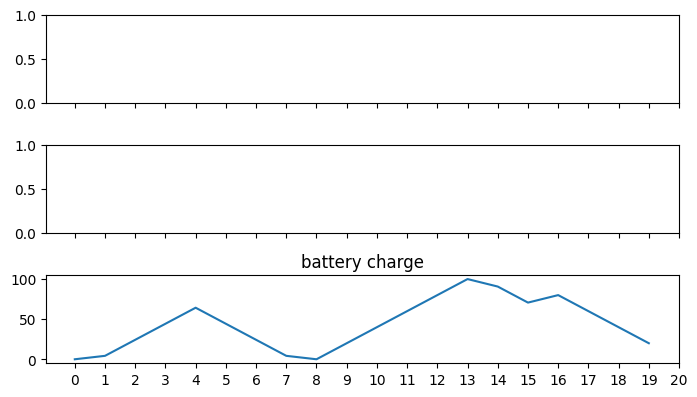

In [14]:
plot_start = 0
plot_end = 20

plotter(
    data = 0,
    action = 0,
    battery = 1,
    net_energy = 0,
    act = act[plot_start:plot_end],
    battery_ = battery_[plot_start:plot_end],
    net_energy_=net_energy_[plot_start:plot_end] ,
    load=load[plot_start:plot_end],
    solar=solar[plot_start:plot_end],
    wind=wind[plot_start:plot_end],
    price=price[plot_start:plot_end],

)

In [15]:
import pickle as pkl

# Dump a variable in a piclke file

pkl.dump({
    "act": action,
    "battery_": battery,
    "net_en": net_energy,
    "load":load,
    "solar":solar,
    "wind":wind,
    "price": price
}, open("results.pkl", "wb"))
    

In [ ]:
#Read piclke file of results

results = pkl.load(open("results.pkl", "rb"))

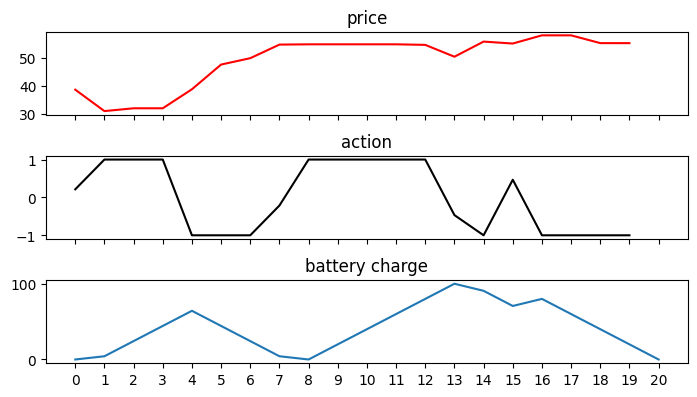

In [11]:
plot_start = 0
plot_end = 20

plotter(
    data = 1,
    action = 1,
    battery = 1,
    net_energy = 0,
    act = act[plot_start:plot_end],
    battery_ = battery_[plot_start:plot_end+1],
    net_energy_=net_energy_[plot_start:plot_end] ,
    load=load[plot_start:plot_end],
    solar=solar[plot_start:plot_end],
    wind=wind[plot_start:plot_end],
    price=price[plot_start:plot_end],

)

In [17]:
# Considering Wind and Solar Generation
cost = 0
for i in range(steps):
    net_energy__ = load[i]-solar[i]-wind[i]
    if net_energy__ > 0:
        cost += net_energy__*price[i]
    else:
        cost += net_energy__*price[i]*parameters['sell_back_price_factor']
print('Real Cost', cost)
print('Optimised Cost', optimalCost)
print('Money Saved', cost - optimalCost)
print('Percentage Saved', (cost - optimalCost)*100/cost)


Real Cost 998615.8138257643
Optimised Cost -397992.2393908221
Money Saved 1396608.0532165864
Percentage Saved 139.8543898344737
